

This code is based on the work "Dynamic Point Fields: Learning Surface Deformation by **Author**: [Sergey Prokudin](https://scholar.google.com/citations?user=xSywCzAAAAAJ).
[[Project Page](https://sergeyprokudin.github.io/dpf/)]
[[Paper](https://arxiv.org/abs/2304.02626)]
[[Video](https://www.youtube.com/watch?v=i-9eAgS8HEA)]
[[GitHub](https://github.com/sergeyprokudin/dpf)]
 and was adapted to the set task of "Same Class Deformation". Where a source model will be deformed to represent a target model, with AIAP as a limiting factor to keep the source shape to some degree.

### Main steps:

1. Download the mesh of choice (optional)
2. Sample points from the surface to form initial point cloud;
3. Optimise point locations and normals to fit the target mesh and its renderings, w.r.t. Chamfer distance, normal Chamfer distance and image-based normal loss;
4. Render and save the final optimised cloud.
5. Define the SIREN deformation network.
6. Optimise deformation network based on the combination of losses: Chamfer distance, as-isometric-as-possible-regularisation (AIAP)
7. Visualise the deformed source mesh
8. Evaluate the deformed surface with its Chamfer distance


### Notes
For citing Dynamic Point Fields by Sergey Prokudin:
```bibtex
@article{prokudin2023dynamic,
                  title={Dynamic Point Fields},
                  author={Prokudin, Sergey and Ma, Qianli and Raafat, Maxime and Valentin, Julien and Tang, Siyu},
                  journal={arXiv preprint arXiv:2304.02626},
                  year={2023}
                }
```


In [1]:
# @title Install dependencies: pytorch3d, point-cloud-utils, trimesh

import sys
import torch
pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
version_str="".join([
    f"py3{sys.version_info.minor}_cu",
    torch.version.cuda.replace(".",""),
    f"_pyt{pyt_version_str}"
])

from zipfile import ZipFile
import os

!wget http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip

with ZipFile('ModelNet10.zip', 'r') as ziped_file:
    ziped_file.extractall()

#similar tables
#20,25,31
#7(round), 47, 50 ,76

#Easiest pair
source_file="/home/martin/Changed_Dynamic_Point_Field/ModelNet10/table/train/table_0025.off"
target_file="/home/martin/Changed_Dynamic_Point_Field/ModelNet10/table/train/table_0020.off"


#To show the limits
#source_file="ModelNet10\table\train\table_0015.off"
#target_file="ModelNet10\table\train\table_0029.off"

#another round table
#target_file="ModelNet10\table\train\table_0057.off"

#source_file="ModelNet10\table\train\table_0030.off"
#target_file="ModelNet10\table\train\table_0057.off"


#source_file="/home/martin/Changed_Dynamic_Point_Field/Dino/mesh_clean1.ply"
#target_file="/home/martin/Changed_Dynamic_Point_Field/Dino/mesh_clean2.ply"
#target_file="/home/martin/Changed_Dynamic_Point_Field/ModelNet10/table/train/table_0020.off"


--2024-07-03 23:50:22--  http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Resolving 3dvision.princeton.edu (3dvision.princeton.edu)... 128.112.136.67
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.67|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip [following]
--2024-07-03 23:50:22--  https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473402300 (451M) [application/zip]
Saving to: ‘ModelNet10.zip.4’

ModelNet10.zip.4    100%[===================>] 451.47M  7.41MB/s    in 46s     

2024-07-03 23:51:09 (9.75 MB/s) - ‘ModelNet10.zip.4’ saved [473402300/473402300]



In [2]:
# @title Import libraries, define the necessary auxiliary functions (mesh normalisation, rendering, etc.)

import numpy as np
#progress bar ?
from tqdm import tqdm
# pytorch for machine learning
#import torch
#  load OBJ files as pytorch3D meshes.
from pytorch3d.io import load_objs_as_meshes
#from pytorch3d.io import _load_off_stream
# import class "meshes" - see https://pytorch3d.readthedocs.io/en/latest/modules/structures.html
from pytorch3d.structures import Meshes, Pointclouds
#from pytorch3d.off_io import MeshOffFormat

from pytorch3d.io import IO

# to load an off mesh--------------------------------------------
import trimesh
import matplotlib.pyplot as plt

# classes and modules from renderer - see https://pytorch3d.readthedocs.io/en/latest/modules/renderer/index.html
from pytorch3d.renderer import (
    Textures,
    #TextureVertex was added by me
    TexturesVertex,
    look_at_view_transform,
    # Field of View
    FoVOrthographicCameras,
    Materials,
    #mapping from 3d scene to 2d image (not rendering , here is just the mapping)
    RasterizationSettings,
    BlendParams,
    MeshRenderer,
    #Rasterizes meshes into images
    MeshRasterizer,
    AmbientLights,
    #color shaing ?
    HardPhongShader,
)

# Constants for magic numbers
DEVICE = 'cuda'
DEFAULT_IMAGE_SIZE = 512
NUM_IMAGES = 100
DEFAULT_SCALE_VAL = 1.0
DEFAULT_RANDOM_SEED = 13

def normals_to_rgb(normals: torch.Tensor) -> torch.Tensor:
    """
    Convert mesh normals to RGB color representation.

    Args:
        normals (torch.Tensor): Mesh normals.

    Returns:
        torch.Tensor: RGB colors based on the normals.
    """
    # value range is now [0,1] , befor it was [-1,1]
    return torch.abs(normals * 0.5 + 0.5)

def get_normals_as_textures(mesh: Meshes) -> Meshes:
    """
    Create textures from mesh normals.

    Args:
        mesh (Meshes): Input mesh.

    Returns:
        Meshes: New mesh with normals as textures.
    """
    #get normals as tensor from mesh object
    normals = mesh.verts_normals_packed()

    #change normals into range [0,1] , unsqueeze is needed for the "Textures or TexturesVertex" function
    #"Textures or TexturesVertex" function creates with the "normals_to_rgb" colored textures for the meshes (see images above)
    colors=normals_to_rgb(normals)
    textures = TexturesVertex(colors.unsqueeze(0))

    #takes the original (input) meseh vertices and faces and adds the color textures to the vertices and faces
    return Meshes(mesh.verts_packed().unsqueeze(0), mesh.faces_packed().unsqueeze(0), textures)



def normalize_verts(vertices: torch.Tensor, scale=None, center=None) -> tuple:
    """
    Normalize vertex positions of a mesh.

    Args:
        vertices (torch.Tensor): Vertex positions.
        scale (float, optional): Scaling factor. Defaults to None.
        center (torch.Tensor, optional): Center of the mesh. Defaults to None.

    Returns:
        tuple: Normalized vertex positions, scaling factor, and center.
    """

    # if center andscale known then centers the vertices around the origin and scales them
    if scale is not None and center is not None:
        vertices = vertices - center
        vertices *= scale
    else:
      #calculate max and min of mesh vertices
        v_max, _ = torch.max(vertices, dim=0)
        v_min, _ = torch.min(vertices, dim=0)
        #calculate center of mesh
        center = (v_max + v_min) / 2.
        #centering around origin
        vertices = vertices - center
        #calc max distance from vertex to origin (euklidean)
        max_dist = torch.sqrt(torch.max(torch.sum(vertices**2, dim=-1)))
        #scaling the max dist vertex to 1
        scale = (1. / max_dist)
        vertices *= scale

        #return vertices , the scale and the center of the mesh
    return vertices, scale, center

def normalize_mesh(mesh: Meshes, scale=None, center=None) -> tuple:
    """
    Normalize a mesh.

    Args:
        mesh (Meshes): Input mesh.
        scale (float, optional): Scaling factor. Defaults to None.
        center (torch.Tensor, optional): Center of the mesh. Defaults to None.

    Returns:
        tuple: Normalized mesh, scaling factor, and center.
    """
    # use function from before
    vertices, scale, center = normalize_verts(mesh.verts_packed(), scale, center)
    #updates the mesh with the normalized vertices to create a new mesh
    normalized_mesh = mesh.update_padded(vertices.unsqueeze(0))
    return normalized_mesh, scale, center

def create_mesh_renderer(cameras, image_size=DEFAULT_IMAGE_SIZE, device='cuda'):
    """
    Create a mesh renderer.

    Args:
        cameras (FoVOrthographicCameras): Camera setup.
        image_size (int, optional): Image size. Defaults to DEFAULT_IMAGE_SIZE.
        device (str, optional): Device for computation. Defaults to 'cuda'.

    Returns:
        MeshRenderer: Mesh renderer.
    """
    materials = Materials(
        device=device,
        specular_color=[[0.0, 0.0, 0.0]],
        shininess=0.0
    )

    raster_settings = RasterizationSettings(
        image_size=image_size,
        blur_radius=0.0,
        faces_per_pixel=1,
        bin_size=None,
        cull_backfaces=True
    )
   
    blend_params = BlendParams(background_color=(0, 0, 0))

    lights = AmbientLights(ambient_color=(1, 1, 1), device=device)

    renderer = MeshRenderer(
        rasterizer=MeshRasterizer(
            cameras=cameras,
            raster_settings=raster_settings
        ),

        shader=HardPhongShader(device=device,
                               cameras=cameras,
                               blend_params=blend_params,
                               lights=lights,
                               materials=materials)
    )

    return renderer

def render_mesh(mesh, dist=1000, elev=0 , azim=0 ,image_size=DEFAULT_IMAGE_SIZE, radius=0.01, scale_val=0.02,device=DEVICE):
    """
    Render a mesh.

    Args:
        mesh (Meshes): Input mesh.
        dist (float, optional): Distance from the camera. Defaults to 1.
        elev (float, optional): Elevation angle. Defaults to 0.
        azim (float, optional): Azimuth angle. Defaults to 0.
        image_size (int, optional): Image size. Defaults to DEFAULT_IMAGE_SIZE.
        radius (float, optional): Radius. Defaults to 0.01.
        scale_val (float, optional): Scaling value. Defaults to 1.0.
        device (str, optional): Device to use for rendering. Defaults to DEVICE.

    Returns:
        torch.Tensor: Rendered image.
    """
    #get Rotation and Translation matrix for camera position at the set values
    R, T = look_at_view_transform(dist=dist, elev=elev, azim=azim)
    # move camera to the set position and scale
    cam = FoVOrthographicCameras(R=R, T=T, scale_xyz=((scale_val, scale_val, scale_val),)).to(device)

    renderer = create_mesh_renderer(cam, image_size=image_size)
   
    img = renderer(mesh, cameras=cam)[0]

    return img

def generate_render_data(mesh,
                         n_images=NUM_IMAGES,
                         scale_val=DEFAULT_SCALE_VAL,
                         rand_seed=DEFAULT_RANDOM_SEED,
                         image_size=DEFAULT_IMAGE_SIZE,
                         device=DEVICE):
    """
    Generate rendering data.

    Args:
        mesh (Meshes): Input mesh.
        n_images (int, optional): Number of images to generate. Defaults to NUM_IMAGES.
        scale_val (float, optional): Scaling value. Defaults to DEFAULT_SCALE_VAL.
        rand_seed (int, optional): Random seed. Defaults to DEFAULT_RANDOM_SEED.
        image_size (int, optional): Image size. Defaults to DEFAULT_IMAGE_SIZE.
        device (str, optional): Device to use for rendering. Defaults to DEVICE.
    Returns:
        tuple: Azimuth angles, elevation angles, and rendered images.
    """

    np.random.seed(rand_seed)
    ygts = []
    azims, elevs = [], []
    # get random angles
    #tqdm is "loading bar"
    for ix in tqdm(range(0, n_images)):
        azims.append(np.random.choice(360))
        elevs.append(np.random.choice(180))

        #render the mesh with given angles
        ygts.append(render_mesh(mesh.to(device),
                                azim=azims[ix],
                                elev=elevs[ix],
                                scale_val=scale_val,
                                image_size=image_size,
                                ).detach().cpu()[:, :, 0:3])

    #reset random seed ?
    np.random.seed(None)

    return azims, elevs, ygts

    # with this the function for mesh preparations are complete



In [3]:
# Load and normalise GT mesh

"""
# load mesh
mesh = trimesh.load('table_0001.off')
v,f = torch.from_numpy(mesh.vertices),torch.from_numpy(mesh.faces)
mesh_gt = Meshes(verts=[v], faces=[f]).to(DEVICE)
mesh_gt=mesh_gt.float()
#GT_MESH_PATH = 'lego_gt.obj'
"""


mesh_gt_source = IO().load_mesh(source_file, device=DEVICE)
mesh_gt_source = get_normals_as_textures(mesh_gt_source).to(DEVICE)
mesh_gt_source_norm, vscale_source, vcenter_source = normalize_mesh(mesh_gt_source)

mesh_gt_target = IO().load_mesh(target_file, device=DEVICE)
mesh_gt_target = get_normals_as_textures(mesh_gt_target).to(DEVICE)
mesh_gt_target_norm, vscale_target, vcenter_target = normalize_mesh(mesh_gt_target)


In [4]:
# Generate renders of the GT mesh (used for training with image-space normal loss)

#N_TRAIN_IMAGES = 200
N_TRAIN_IMAGES = 100

azims_train_source, elevs_train_source,  ygts_train_source = generate_render_data(mesh_gt_source_norm,
                                                        n_images=N_TRAIN_IMAGES,
                                                        scale_val=1.0,
                                                        rand_seed=19,
                                                        image_size=DEFAULT_IMAGE_SIZE)

azims_train_target, elevs_train_target,  ygts_train_target = generate_render_data(mesh_gt_target_norm,
                                                        n_images=N_TRAIN_IMAGES,
                                                        scale_val=1.0,
                                                        rand_seed=19,
                                                        image_size=DEFAULT_IMAGE_SIZE)


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.97it/s]


In [5]:
"""
import matplotlib.pyplot as plt

# visualised GT mesh
plt.figure()
plt.title("GT mesh source")
plt.imshow(ygts_train_source[np.random.choice(N_TRAIN_IMAGES)])

plt.figure()
plt.title("GT mesh target")
plt.imshow(ygts_train_target[np.random.choice(N_TRAIN_IMAGES)])
"""

'\nimport matplotlib.pyplot as plt\n\n# visualised GT mesh\nplt.figure()\nplt.title("GT mesh source")\nplt.imshow(ygts_train_source[np.random.choice(N_TRAIN_IMAGES)])\n\nplt.figure()\nplt.title("GT mesh target")\nplt.imshow(ygts_train_target[np.random.choice(N_TRAIN_IMAGES)])\n'

In [6]:
# @title Define functions for point rendering and optimisation

from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.structures import Pointclouds
from pytorch3d.renderer import (
    PointsRasterizationSettings,
    PointsRasterizer,
    PointsRenderer,
    AlphaCompositor
)
from pytorch3d.loss import chamfer_distance

# not sure about points per pixel
POINTS_PER_PIXEL = 50

def get_point_renderer(image_size, radius=0.05, points_per_pixel=50):



  raster_settings = PointsRasterizationSettings(
      image_size=image_size,
      radius = radius,
      points_per_pixel = points_per_pixel
      )

  rasterizer = PointsRasterizer(cameras=FoVOrthographicCameras(),
                                raster_settings=raster_settings)
  renderer = PointsRenderer(
      rasterizer=rasterizer,
      compositor=AlphaCompositor(background_color=(1, 1, 1))
      
      #compositor=NormWeightedCompositor()
  )

  return renderer

def render_points(x, xf, dist=1, elev=0, azim=0, image_size=512,
                  radius=0.01, points_per_pixel=50, scale_val=1.0,
                  device=DEVICE):

  x = x.to(device)
  xf = xf.to(device)
  renderer = get_point_renderer(image_size=image_size, radius=radius, points_per_pixel=points_per_pixel)
  R, T = look_at_view_transform(dist=dist, elev=elev, azim=azim)
  cam = FoVOrthographicCameras(R=R, T=T, scale_xyz=((scale_val, scale_val, scale_val),)).to(device)

  pcl = Pointclouds(points=x.unsqueeze(0), features=xf.unsqueeze(0)).to(device)

  img = renderer(pcl, cameras=cam)[0]

  return img





In [7]:
# Sample initial points and corresponding normals

import point_cloud_utils as pcu

# uncomment the line for desired number of points and corresponding radius
# NUM_POINTS, POINT_RADIUS = 10**4, 0.025
# NUM_POINTS, POINT_RADIUS = 10**5, 0.009
NUM_POINTS, POINT_RADIUS = 3*10**5, 0.007
# NUM_POINTS, POINT_RADIUS = 10**6, 0.004

#return points and corresponding normals
v0_source, n0_source = sample_points_from_meshes(mesh_gt_source.to(DEVICE),
                                   return_normals=True,
                                   num_samples=NUM_POINTS)
# and saved as paramters for optimization, grad is for gradient descent for autograd?
v0_source = torch.nn.Parameter(v0_source[0].clone().to(DEVICE), requires_grad=True)
n0_source = torch.nn.Parameter(n0_source[0].clone().to(DEVICE), requires_grad=True)

#save as "ply" file
# save the initial cloud for evaluation at the end
pcu.save_mesh_vn('init_source.ply', v0_source.detach().cpu().numpy(), n0_source.detach().cpu().numpy())



v0_target, n0_target = sample_points_from_meshes(mesh_gt_target.to(DEVICE),
                                   return_normals=True,
                                   num_samples=NUM_POINTS)
# and saved as paramters for optimization, grad is for gradient descent for autograd?
v0_target = torch.nn.Parameter(v0_target[0].clone().to(DEVICE), requires_grad=True)
n0_target = torch.nn.Parameter(n0_target[0].clone().to(DEVICE), requires_grad=True)

#save as "ply" file
# save the initial cloud for evaluation at the end
pcu.save_mesh_vn('init_target.ply', v0_target.detach().cpu().numpy(), n0_target.detach().cpu().numpy())



In [8]:
# render initial, non-optimised cloud

#select random iamge from train data set
DEMO_FRAME_IX = np.random.choice(N_TRAIN_IMAGES)

#normalize the points(vectrices) of the pointcloud v0 around the origin, like before with mesehs
v0_norm_source, _, _ = normalize_verts(v0_source, vscale_source, vcenter_source)

ypred_init_source = render_points(v0_norm_source.to(DEVICE),
                      normals_to_rgb(n0_source.to(DEVICE)),
                      elev=elevs_train_source[DEMO_FRAME_IX],
                      azim=azims_train_source[DEMO_FRAME_IX],
                      image_size=DEFAULT_IMAGE_SIZE,
                      points_per_pixel=POINTS_PER_PIXEL,
                      radius=POINT_RADIUS).detach().cpu().numpy()

#print a demo of the point cloud and the corresponding ground truth mesh
ygt_demo_source = ygts_train_source[DEMO_FRAME_IX].detach().cpu().numpy()
"""
plt.figure()
plt.title("Initial cloud (non-optimized) source")
plt.imshow(ypred_init_source)

plt.figure()
plt.title("Ground truth mesh source")
plt.imshow(ygt_demo_source)
"""

#select random iamge from train data set
DEMO_FRAME_IX = np.random.choice(N_TRAIN_IMAGES)

#normalize the points(vectrices) of the pointcloud v0 around the origin, like before with mesehs
v0_norm_target, _, _ = normalize_verts(v0_target, vscale_target, vcenter_target)

ypred_init_target = render_points(v0_norm_target.to(DEVICE),
                      normals_to_rgb(n0_target.to(DEVICE)),
                      elev=elevs_train_target[DEMO_FRAME_IX],
                      azim=azims_train_target[DEMO_FRAME_IX],
                      image_size=DEFAULT_IMAGE_SIZE,
                      points_per_pixel=POINTS_PER_PIXEL,
                      radius=POINT_RADIUS).detach().cpu().numpy()

#print a demo of the point cloud and the corresponding ground truth mesh
ygt_demo_target = ygts_train_target[DEMO_FRAME_IX].detach().cpu().numpy()
"""
plt.figure()
plt.title("Initial cloud (non-optimized) target")
plt.imshow(ypred_init_target)

plt.figure()
plt.title("Ground truth mesh target")
plt.imshow(ygt_demo_target)
"""

'\nplt.figure()\nplt.title("Initial cloud (non-optimized) target")\nplt.imshow(ypred_init_target)\n\nplt.figure()\nplt.title("Ground truth mesh target")\nplt.imshow(ygt_demo_target)\n'

In [9]:
# @title Run point cloud optimisation
#NUM_EPOCHS = 4
#NUM_GT_EVAL_POINTS = 10**6
#N_ITERS_PER_EPOCH = 20

#NUM_EPOCHS = 1
#NUM_GT_EVAL_POINTS = 10**4
#N_ITERS_PER_EPOCH = 20

NUM_EPOCHS = 4
NUM_GT_EVAL_POINTS = 10**5
N_ITERS_PER_EPOCH = 20



#vs_source = []
#ns_source = []

#mean squared error loss function
mse_loss = torch.nn.MSELoss()

#Adam = Adaptive Moment Estimation (AdaGrad and RMSProp)
#optimazation used to train deep learning models
optv = torch.optim.Adam([v0_source], lr=1.0e-4)
optn = torch.optim.Adam([n0_source], lr=1.0e-2)

#scheduler for vertex , when a there is only little change in loss then the learning rate is reduced
schedv = torch.optim.lr_scheduler.ReduceLROnPlateau(optv, patience=1)


#same for normals
schedn = torch.optim.lr_scheduler.ReduceLROnPlateau(optn, patience=1)


#total loss
tloss = 0
n_r = 0

#loading bar
for i in tqdm(range(0, NUM_EPOCHS)):

  # random set of training images is selected ( wiht no replace)
  epoch_fids = np.random.choice(len(azims_train_source), N_ITERS_PER_EPOCH, replace=False)


  chamfer_loss_total = 0
  l2_norm_total = 0
  cosine_normal_loss_total = 0
  n_r = 0
# work through the selected set
  for ix in epoch_fids:

#sample points from mesh
    vgt_source, vgtn_source = sample_points_from_meshes(mesh_gt_source.to(DEVICE),
                        return_normals=True,
                        num_samples=NUM_GT_EVAL_POINTS)

#normalize the points
    v0_norm_source, _, _ = normalize_verts(v0_source, vscale_source, vcenter_source)
    ypred_source = render_points(v0_norm_source.to(DEVICE),
                      normals_to_rgb(n0_source.to(DEVICE)),
                      elev=elevs_train_source[ix],
                      azim=azims_train_source[ix],
                      image_size=DEFAULT_IMAGE_SIZE,
                      points_per_pixel=POINTS_PER_PIXEL,
                      radius=POINT_RADIUS)

#mse error between the ground truth mesh and the render sampled points
    l2_norm = 10*mse_loss(ygts_train_source[ix].to(DEVICE), ypred_source)
#chamfer loss - the sum of the min distance between each point of cloud A to B and cloud B to A
#cosine loss - how similar are the normals of these closest points
    chamfer_loss, cosine_normal_loss = chamfer_distance(vgt_source, v0_source.unsqueeze(0), x_normals=vgtn_source, y_normals=n0_source.unsqueeze(0), norm=2)

    chamfer_loss, normal_loss = 10**4*chamfer_loss, cosine_normal_loss
    loss = chamfer_loss + cosine_normal_loss + 10*l2_norm

    chamfer_loss_total += float(chamfer_loss)
    cosine_normal_loss_total += float(cosine_normal_loss)
    l2_norm_total += float(l2_norm)
    n_r += 1
    optv.zero_grad()
    optn.zero_grad()
    loss.backward()
    optv.step()
    optn.step()


  chamfer_loss_total /= n_r
  l2_norm_total /= n_r
  cosine_normal_loss_total /= n_r
  print("Chamfer loss: %f, cosine normal loss: %f,  L2 image normal loss: %f" % (chamfer_loss_total, cosine_normal_loss_total, l2_norm_total))
  total_loss = chamfer_loss_total + l2_norm_total
  schedv.step(float(total_loss))
  schedn.step(float(total_loss))

 25%|█████████████████████▎                                                               | 1/4 [00:08<00:24,  8.33s/it]

Chamfer loss: 68.220458, cosine normal loss: 0.025406,  L2 image normal loss: 7.154769


 50%|██████████████████████████████████████████▌                                          | 2/4 [00:16<00:16,  8.38s/it]

Chamfer loss: 68.039106, cosine normal loss: 0.025143,  L2 image normal loss: 7.214200


 75%|███████████████████████████████████████████████████████████████▊                     | 3/4 [00:25<00:08,  8.39s/it]

Chamfer loss: 67.804996, cosine normal loss: 0.025832,  L2 image normal loss: 7.401222


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:33<00:00,  8.37s/it]

Chamfer loss: 67.614781, cosine normal loss: 0.026510,  L2 image normal loss: 7.102796


In [10]:
## @title Run point cloud optimisation

#vs_target = []
#ns_target = []

#mean squared error loss function
mse_loss = torch.nn.MSELoss()

#Adam = Adaptive Moment Estimation (AdaGrad and RMSProp)
#optimazation used to train deep learning models
optv = torch.optim.Adam([v0_target], lr=1.0e-4)
optn = torch.optim.Adam([n0_target], lr=1.0e-2)

#scheduler for vertex , when a there is only little change in loss then the learning rate is reduced
schedv = torch.optim.lr_scheduler.ReduceLROnPlateau(optv, patience=1)


#same for normals
schedn = torch.optim.lr_scheduler.ReduceLROnPlateau(optn, patience=1)


#total loss ?
tloss = 0
n_r = 0

#loading bar
for i in tqdm(range(0, NUM_EPOCHS)):

  # random set of training images is selected ( wiht no replace)
  epoch_fids = np.random.choice(len(azims_train_target), N_ITERS_PER_EPOCH, replace=False)


  chamfer_loss_total = 0
  l2_norm_total = 0
  cosine_normal_loss_total = 0
  n_r = 0
# work through the selected set
  for ix in epoch_fids:

#sample points from mesh
    vgt_target, vgtn_target = sample_points_from_meshes(mesh_gt_target.to(DEVICE),
                        return_normals=True,
                        num_samples=NUM_GT_EVAL_POINTS)

#normalize the points
    v0_norm_target, _, _ = normalize_verts(v0_target, vscale_target, vcenter_target)
    ypred_target = render_points(v0_norm_target.to(DEVICE),
                      normals_to_rgb(n0_target.to(DEVICE)),
                      elev=elevs_train_target[ix],
                      azim=azims_train_target[ix],
                      image_size=DEFAULT_IMAGE_SIZE,
                      points_per_pixel=POINTS_PER_PIXEL,
                      radius=POINT_RADIUS)

#mse error between the ground truth mesh and the render sampled points (why times 10???)
    l2_norm = 10*mse_loss(ygts_train_target[ix].to(DEVICE), ypred_target)
#chamfer loss - the sum of the min distance between each point of cloud A to B and cloud B to A
#cosine loss - how similar are the normals of these closes points ?
    chamfer_loss, cosine_normal_loss = chamfer_distance(vgt_target, v0_target.unsqueeze(0), x_normals=vgtn_target, y_normals=n0_target.unsqueeze(0), norm=2)
# why 10^4 ?
    chamfer_loss, normal_loss = 10**4*chamfer_loss, cosine_normal_loss
    loss = chamfer_loss + cosine_normal_loss + 10*l2_norm

    chamfer_loss_total += float(chamfer_loss)
    cosine_normal_loss_total += float(cosine_normal_loss)
    l2_norm_total += float(l2_norm)
    n_r += 1
    optv.zero_grad()
    optn.zero_grad()
    loss.backward()
    optv.step()
    optn.step()

# n_r number of iterations ????
  chamfer_loss_total /= n_r
  l2_norm_total /= n_r
  cosine_normal_loss_total /= n_r
  print("Chamfer loss: %f, cosine normal loss: %f,  L2 image normal loss: %f" % (chamfer_loss_total, cosine_normal_loss_total, l2_norm_total))
  total_loss = chamfer_loss_total + l2_norm_total
  schedv.step(float(total_loss))
  schedn.step(float(total_loss))

    

 25%|█████████████████████▎                                                               | 1/4 [00:08<00:24,  8.27s/it]

Chamfer loss: 410.990347, cosine normal loss: 0.026317,  L2 image normal loss: 7.461866


 50%|██████████████████████████████████████████▌                                          | 2/4 [00:16<00:16,  8.31s/it]

Chamfer loss: 410.077507, cosine normal loss: 0.025482,  L2 image normal loss: 8.074019


 75%|███████████████████████████████████████████████████████████████▊                     | 3/4 [00:24<00:08,  8.32s/it]

Chamfer loss: 410.384116, cosine normal loss: 0.025277,  L2 image normal loss: 7.857590


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:33<00:00,  8.32s/it]

Chamfer loss: 409.728865, cosine normal loss: 0.025558,  L2 image normal loss: 7.871453


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


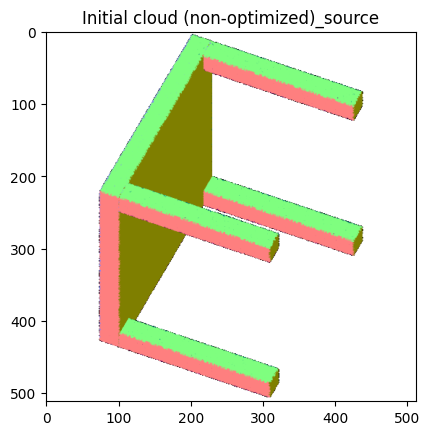

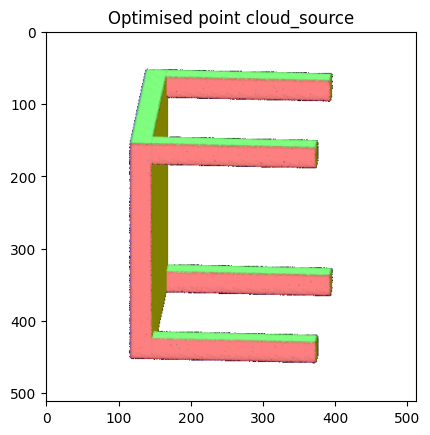

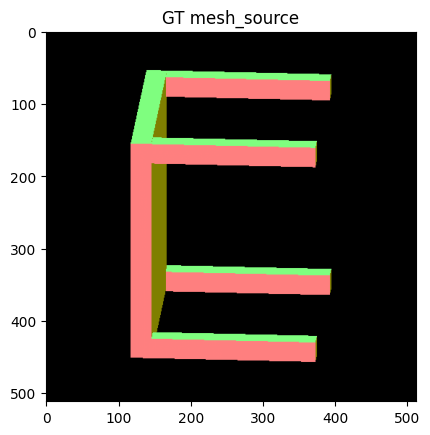

In [11]:
# Render the optimised cloud

ypred_source = render_points(v0_norm_source.to(DEVICE),
                      normals_to_rgb(n0_source.to(DEVICE)),
                      elev=elevs_train_source[DEMO_FRAME_IX],
                      azim=azims_train_source[DEMO_FRAME_IX],
                      image_size=DEFAULT_IMAGE_SIZE,
                      points_per_pixel=POINTS_PER_PIXEL,
                      radius=POINT_RADIUS)

plt.figure()
plt.title("Initial cloud (non-optimized)_source")
plt.imshow(ypred_init_source)

#ypred_source_color=normalize_verts_color(ypred_source)

plt.figure()
plt.title("Optimised point cloud_source")
plt.imshow(ypred_source.detach().cpu().numpy())

plt.figure()
plt.title("GT mesh_source")
plt.imshow(ygts_train_source[DEMO_FRAME_IX][:, :, 0:3].detach().cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


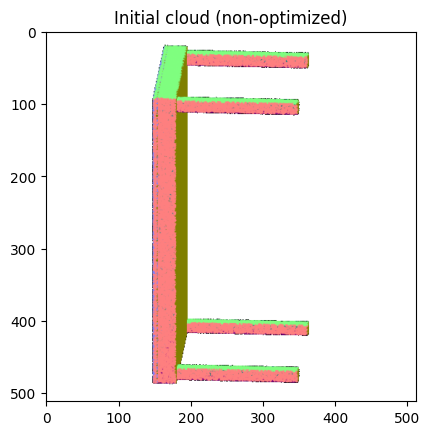

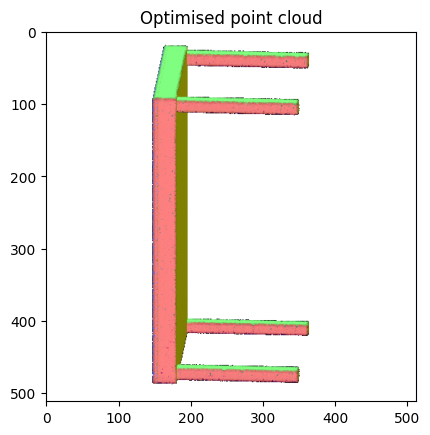

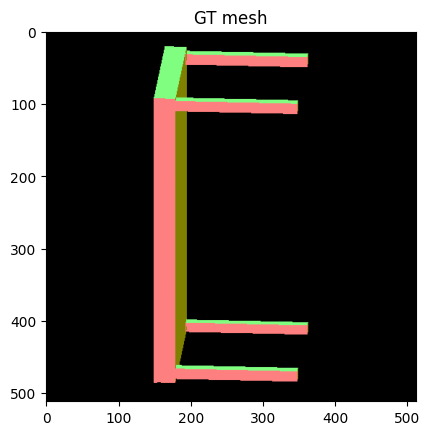

In [12]:
## Render the optimised cloud

ypred_target = render_points(v0_norm_target.to(DEVICE),
                      normals_to_rgb(n0_target.to(DEVICE)),
                      elev=elevs_train_target[DEMO_FRAME_IX],
                      azim=azims_train_target[DEMO_FRAME_IX],
                      image_size=DEFAULT_IMAGE_SIZE,
                      points_per_pixel=POINTS_PER_PIXEL,
                      radius=POINT_RADIUS)

plt.figure()
plt.title("Initial cloud (non-optimized)")
plt.imshow(ypred_init_target)

plt.figure()
plt.title("Optimised point cloud")
plt.imshow(ypred_target.detach().cpu().numpy())

plt.figure()
plt.title("GT mesh")
plt.imshow(ygts_train_target[DEMO_FRAME_IX][:, :, 0:3].detach().cpu().numpy())

In [13]:
# @title Define functions for surface reconstruction

from pytorch3d.io import IO
from scipy.stats import sem
import point_cloud_utils as pcu

device = 'cuda'

def chamfer_eval(x, y, xn, yn):
    """
    Compute the chamfer distance and cosine normals between two point sets.

    Args:
        x (torch.Tensor): The first set of points (B x N x 3).
        y (torch.Tensor): The second set of points (B x M x 3).
        xn (torch.Tensor): The normals of the first set of points (B x N x 3).
        yn (torch.Tensor): The normals of the second set of points (B x M x 3).
        verbose (bool): If True, print the computed chamfer distances and cosine normals.

    Returns:
        torch.Tensor: The chamfer distance between x and y (B).
        torch.Tensor: The cosine normals between xn and yn (B).
    """
    l2_chamfer, l2_normals = chamfer_distance(x, y, x_normals=xn, y_normals=yn, norm=2)
    l2_chamfer, l2_normals = (10**4) * l2_chamfer, l2_normals


def eval_surface_reconstruction_cloud(pred_cloud_path, gt_mesh_path, n_samples=10**6, device='cuda'):
    """
    Evaluate the surface reconstruction performance for a point cloud and a mesh.

    Args:
        pred_cloud_path (str): The file path to the predicted point cloud.
        gt_mesh_path (str): The file path to the ground truth mesh.
        n_samples (int): The number of points to sample from the mesh. Defaults to 10^6.
        device (str): The device to perform computations on. Defaults to 'cuda'.

    Returns:
        torch.Tensor: The chamfer distance between predicted point cloud and ground truth mesh.
        torch.Tensor: The cosine normals between predicted point cloud and ground truth mesh.
    """
    gt_mesh = IO().load_mesh(gt_mesh_path, device=device)

    pred_points, pred_normals = pcu.load_mesh_vn(pred_cloud_path)
    pred_points = torch.Tensor(pred_points).unsqueeze(0).to(device)
    pred_normals = torch.Tensor(pred_normals).unsqueeze(0).to(device)

    gt_points, gt_normals = sample_points_from_meshes(gt_mesh, return_normals=True, num_samples=n_samples)

    l2_chamfer, l2_normals = chamfer_eval(gt_points, pred_points, gt_normals, pred_normals)

    return l2_chamfer, l2_normals


In [14]:
# Save the optimised cloud, evaluate
#pcu.save_mesh_vn('pcd_source.ply', v0_source.detach().cpu().numpy(), n0_source.detach().cpu().numpy())

pcu.save_mesh_v('pcd_source.ply', v0_norm_source.detach().cpu().numpy())

#pcu.save_mesh_vn('pcd_target.ply', v0_norm_target.detach().cpu().numpy(), n0_target.detach().cpu().numpy())
pcu.save_mesh_v('pcd_target.ply', v0_norm_target.detach().cpu().numpy())


In [15]:
# Now the deformation

In [16]:
# @title Import libraries, define the necessary auxiliary functions (mesh normalisation, rendering, etc.)

#import numpy as np
#from tqdm import tqdm
#import torch
#from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    Textures,
    look_at_view_transform,
    FoVOrthographicCameras,
    Materials,
    RasterizationSettings,
    BlendParams,
    MeshRenderer,
    MeshRasterizer,
    AmbientLights,
    HardPhongShader,
)
from scipy.spatial.transform import Rotation as R

# Constants for magic numbers
DEVICE = 'cuda'
DEFAULT_IMAGE_SIZE = 512
DEFAULT_SCALE_VAL = 1.0
DEFAULT_RANDOM_SEED = 13


def rotate_mesh90(mesh):
# rotate around x axis ???
  rotmat = torch.Tensor(R.from_rotvec(np.pi/2 * np.array([1, 0, 0])).as_matrix()).to(DEVICE)
  rotated_verts = mesh.verts_packed() @ rotmat

  return Meshes(rotated_verts.unsqueeze(0), mesh.faces_packed().unsqueeze(0), textures=mesh.textures)

/tmp/ipykernel_32848/3389362316.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vsrc_norm_colors,_,_=normalize_verts_color(torch.tensor(v0_norm_source).to(DEVICE))
/tmp/ipykernel_32848/3389362316.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vtrg_norm_colors,_,_=normalize_verts_color(torch.tensor(v0_norm_target).to(DEVICE))


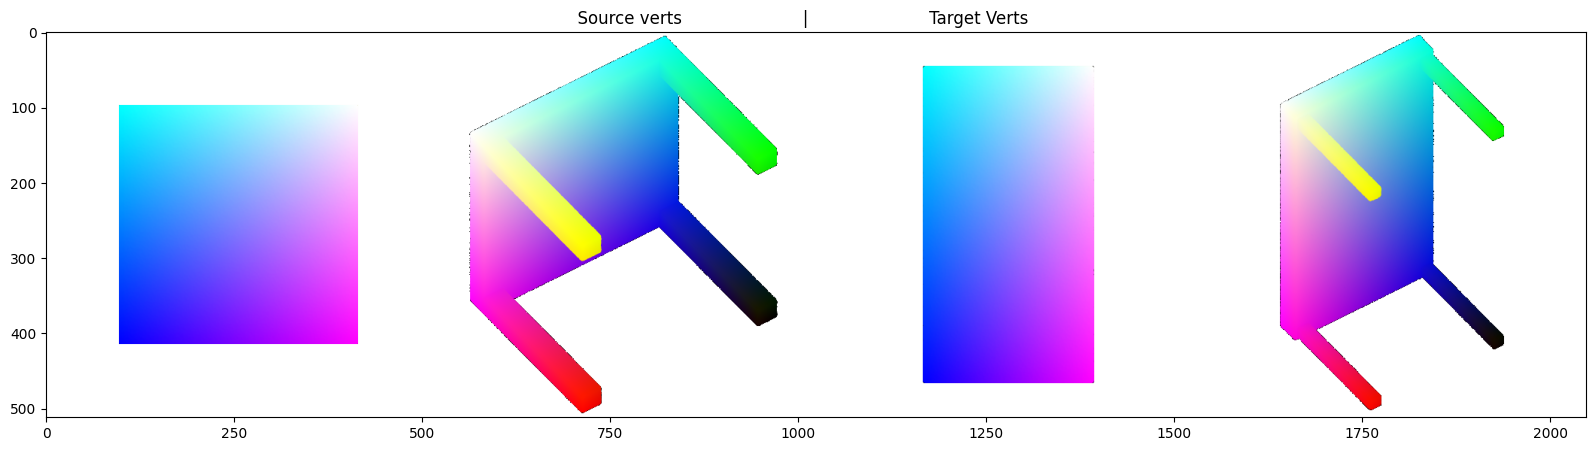

In [17]:
# changed function
def normalize_verts_color(vertices: torch.Tensor, scale=None, center=None) -> tuple:
    """
    Normalize vertex positions of a mesh.

    Args:
        vertices (torch.Tensor): Vertex positions.
        scale (float, optional): Scaling factor. Defaults to None.
        center (torch.Tensor, optional): Center of the mesh. Defaults to None.

    Returns:
        tuple: Normalized vertex positions with corresponding "colors to position", scaling factor, and center.
    """

    # if center andscale known then centers the vertices around the origin and scales them
    if scale is not None and center is not None:
        vertices = vertices - center
        vertices *= scale
    else:
        #calculate max and min of mesh vertices
        v_max, _ = torch.max(vertices, dim=0)
        v_min, _ = torch.min(vertices, dim=0)
        #calculate center of mesh
        center = (v_max + v_min) / 2.
        #centering around origin
        vertices = vertices - center
        #calc max distance from vertex to origin (euklidean)
        max_dist = torch.sqrt(torch.max(torch.sum(vertices**2, dim=-1)))
        #scaling the max dist vertex to 1
        scale = (1. / max_dist)
        vertices *= scale

        #now take the coordinates to change these values into color, depending on the position of the scaled version
        colors = torch.zeros_like(vertices)

        # take axis position for "color channel"
        colors[:, 0] = vertices[:, 0]  #red for x
        colors[:, 1] = vertices[:, 1]  #green for y
        colors[:, 2] = vertices[:, 2]  #blue for z

        # normalization of color like for the vertices
        #calculate max and min of color
        max_values = colors.max(dim=0)[0]
        min_values = colors.min(dim=0)[0]
        
        # Normalize the color channels like above
        normalized_colors = (colors - min_values) / (max_values - min_values)

        #add the color tensor to vertex tensor
        vertices_with_colors = torch.cat((vertices, normalized_colors), dim=1)

        #return vertices with color , the scale and the center of the mesh
    return vertices_with_colors, scale, center


def render_points_color(x,c, dist=1, elev=0, azim=0, image_size=512,
                  radius=0.01, points_per_pixel=50, scale_val=1.0,
                  device=DEVICE):
  # color = feature
  x = x.to(device)
  c = c.to(device)
    
  renderer = get_point_renderer(image_size=image_size, radius=radius, points_per_pixel=points_per_pixel)
  R, T = look_at_view_transform(dist=dist, elev=elev, azim=azim)
  cam = FoVOrthographicCameras(R=R, T=T, scale_xyz=((scale_val, scale_val, scale_val),)).to(device)

  #pcl = Pointclouds(points=x.unsqueeze(0).to(device),features=c.unsqueeze(0).to(device))
  pcl=Pointclouds(points=[x], features=[c])

  img = renderer(pcl, cameras=cam)[0]
    
  return img








############################################################################################################################################################################
############################################################################################################################################################################
############################################################################################################################################################################

#v0_norm_source=v0_norm_source.clone()
#v0_norm_target=v0_norm_target.clone()

#IF preprocessed oject are used, like for the hand picked keypoints !!!
# otherwise comment the next four lines

source_file='pcd_table0025.ply'
v0_norm_source = torch.Tensor(pcu.load_mesh_v(source_file))
target_file='pcd_table0020.ply'
v0_norm_target = torch.Tensor(pcu.load_mesh_v(target_file))

v0_norm_source=v0_norm_source.clone()
v0_norm_target=v0_norm_target.clone()

# normalize and add color
vsrc_norm_colors,_,_=normalize_verts_color(torch.tensor(v0_norm_source).to(DEVICE))
vtrg_norm_colors,_,_=normalize_verts_color(torch.tensor(v0_norm_target).to(DEVICE))

#separate the color from the positions ( index of the point will not change later but throught the transformation the position coordiantes, so the color from the beginning can be added later to the same "point")
vsrc_pos = vsrc_norm_colors[:, :3]
vsrc_col = vsrc_norm_colors[:, 3:]
vtrg_pos = vtrg_norm_colors[:, :3]
vtrg_col = vtrg_norm_colors[:, 3:]

yvsrc= render_points_color(x = vsrc_pos,c = vsrc_col)
yvtrg= render_points_color(x = vtrg_pos,c = vtrg_col)

# just to print
yvsrc_print_1=yvsrc.cpu().detach().numpy()
yvtrg_print_1=yvtrg.cpu().detach().numpy()

# print with a second angle 
yvsrc_2= render_points_color(x = vsrc_pos,c=vsrc_col, elev=45, azim=145)
yvtrg_2= render_points_color(x =vtrg_pos,c=vtrg_col, elev=45, azim=145)

yvsrc_print_2=yvsrc_2.cpu().detach().numpy()
yvtrg_print_2=yvtrg_2.cpu().detach().numpy()

y = np.hstack([yvsrc_print_1,yvsrc_print_2, yvtrg_print_1, yvtrg_print_2]).clip(0,1)

plt.figure(figsize=(20, 5))
plt.title("                  Source verts                       |                       Target Verts                       ")
plt.imshow(y)

##############################################################################################################################################

In [18]:
# @title Define SIREN deformation model

#Sinusoidal Representation Network - sinus as nonlinear activation function
#the first and second dreivative has fast convergence and the representations of the derivatives are true
#ReLu MLP not good enaught for complex objects
from torch import nn
#import numpy as np

class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.

    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a
    # hyperparameter.

    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

    def forward_with_intermediate(self, input):
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate


class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False,
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()

        self.net = []
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        #coords = coords#.requires_grad_(True) # allows to take derivative w.r.t. input
        coords = coords.requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output , coords
        #return output #, coords

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)

                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()

                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else:
                x = layer(x)

                if retain_grad:
                    x.retain_grad()

            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

In [19]:
# @title Define deformation learning function and AIAP loss
#from tqdm import tqdm
#import torch
#k-nearest neighbours
from pytorch3d.ops.knn import knn_points
#chamfer_distance - see code 1.1 (sum of distance of .....)
#from pytorch3d.loss.chamfer import chamfer_distance
#import torch
#L1_loss = mean absolute error (robust to outliers) - calc the absolute difference between the predicted and target tensors and averages them
from torch.nn.functional import l1_loss

def aiap_loss(x_canonical, x_deformed, n_neighbors=5):
    """
    Computes the as-isometric-as-possible loss between two sets of points, which measures the discrepancy
    between their pairwise distances.

    Parameters
    ----------
    x_canonical : array-like, shape (n_points, n_dims)
        The canonical (reference) point set, where `n_points` is the number of points
        and `n_dims` is the number of dimensions.
    x_deformed : array-like, shape (n_points, n_dims)
        The deformed (transformed) point set, which should have the same shape as `x_canonical`.
    n_neighbors : int, optional
        The number of nearest neighbors to use for computing pairwise distances.
        Default is 5.

    Returns
    -------
    loss : float
        The AIAP loss between `x_canonical` and `x_deformed`, computed as the L1 norm
        of the difference between their pairwise distances. The loss is a scalar value.
    Raises
    ------
    ValueError
        If `x_canonical` and `x_deformed` have different shapes.
    """

    if x_canonical.shape != x_deformed.shape:
        raise ValueError("Input point sets must have the same shape.")
    
#k-nearest indices of the same points ?
    _, nn_ix, _ = knn_points(x_canonical.unsqueeze(0),
                             x_canonical.unsqueeze(0),
                             K=n_neighbors,
                             return_sorted=True)
#calc the euclidean distance between these points
    dists_canonical = torch.cdist(x_canonical[nn_ix], x_canonical[nn_ix])
    dists_deformed = torch.cdist(x_deformed[nn_ix], x_deformed[nn_ix])

    loss = l1_loss(dists_canonical, dists_deformed)

    return loss


# deformation learning
def deform_cloud(model, xsrc, xtrg, vsrc, vtrg,
                 use_aiap=True, use_aiap_inter=False,
                 use_chamfer=True, use_guidance=False,
                 n_chamfer_samples=10**4, n_steps=2000, init_lr=1.0e-4,                     # normaly 20000
                 aiap_weight=1.0e4, aiap_inter_max=1.0,
                 guided_weight=1.0e4, chamfer_weight=1.0e4,
                 iso_n_neighbors=5, eval_every_nth_step=100, device=DEVICE):
  """
  Deform a point cloud using a neural network model.

  Parameters
  ----------
  model : torch.nn.Module
      The neural network model to use for deformation.
  xsrc : numpy.ndarray
      The source point cloud to deform.
  xtrg : numpy.ndarray, optional
      The target point cloud to match (used in chamfer distance loss).
  vsrc : numpy.ndarray, optional
      The source keypoints to use as guidance for deformation.
  vtrg : numpy.ndarray, optional
      The target keypoints to match (used in guided loss).
  use_aiap : bool, optional
      Whether to use AIAP loss (default is True).
  use_aiap_inter : bool, optional
      Whether to use AIAP loss between halfway frames (default is True).
  use_chamfer : bool, optional
      Whether to use chamfer distance loss (default is True).
  use_guidance : bool, optional
      Whether to use guided loss (default is True).
  n_chamfer_samples : int, optional
      The number of points to sample for chamfer distance loss (default is 10**4).
  n_steps : int, optional
      The number of optimization steps (default is 20000).
  init_lr : float, optional
      The initial learning rate for the optimizer (default is 1.0e-4).
  aiap_weight : float, optional
      The weight for AIAP loss (default is 1.0e4).
  aiap_inter_max : float, optional
      The interval for AIAP loss between frames (default is 1.0). Check Section 3.2 for details
  guided_weight : float, optional
      The weight for guided loss (default is 1.0e4).
  chamfer_weight : float, optional
      The weight for chamfer distance loss (default is 1.0e4).
  iso_n_neighbors : int, optional
      The number of neighbors to use for isometric loss (default is 5).
  eval_every_nth_step : int, optional
      The number of steps between evaluations (default is 100).
  device: str, optional
      Device to use for rendering. Defaults to DEVICE.

  """
 
  model = model.train()
  l1_loss = torch.nn.L1Loss()
  #Adam =Adaptive Moment Estimation - gradiant descent procedure
  optm = torch.optim.Adam(model.parameters(), lr=init_lr)
  schedm = torch.optim.lr_scheduler.ReduceLROnPlateau(optm, patience=1)

  if use_chamfer and xtrg is None:
    print("no target cloud provided, ignoring...")
    use_chamfer = False

  if use_guidance and vtrg is None:
    print("no keypoints provided, ignoring...")
    use_guidance = False

  guided_loss_total = 0
  chamfer_loss_total = 0
  aiap_loss_total = 0
  total_loss = 0
  n_r = 0

  for i in range(0, n_steps):

    if use_aiap or use_chamfer or use_aiap_inter:
      xbatch_src = torch.Tensor(xsrc[np.random.choice(len(xsrc), n_chamfer_samples, replace=False)]).to(device)

      model_output_tuple = model(xbatch_src)
      tensor_from_model_output = model_output_tuple[0]
    
      #xbatch_deformed = xbatch_src + model(xbatch_src)
      xbatch_deformed = xbatch_src + tensor_from_model_output

    if use_aiap_inter:
      # additionally enforce isometry between frames
      t = aiap_inter_max * np.random.uniform()

      #xbatch_deformed_halfway = xbatch_src + aiap_inter_max*model(xbatch_src)
      xbatch_deformed_halfway = xbatch_src + aiap_inter_max*tensor_from_model_output
      
    loss = 0

    if use_aiap:
      iso_loss = aiap_weight*aiap_loss(xbatch_src, xbatch_deformed, n_neighbors=iso_n_neighbors)
      loss += iso_loss
      aiap_loss_total += float(iso_loss)

    if use_aiap_inter:
      iso_loss += aiap_weight*aiap_loss(xbatch_src, xbatch_deformed_halfway, n_neighbors=iso_n_neighbors)
      loss += iso_loss
      aiap_loss_total += float(iso_loss)

    if use_guidance:
        
      model_output_vsrc = model(vsrc)
      tensor_from_model_output_vsrc = model_output_vsrc[0]

      #vsrc_deformed = vsrc + model(vsrc)
      vsrc_deformed = vsrc + tensor_from_model_output_vsrc
        
      guidance_loss = guided_weight*l1_loss(vsrc_deformed, vtrg)
      loss += guidance_loss
      guided_loss_total += float(guidance_loss)

    if use_chamfer:
      xbatch_trg = torch.Tensor(xtrg[np.random.choice(len(xtrg), n_chamfer_samples, replace=False)]).to(device)
      chamfer_loss = chamfer_weight*chamfer_distance(xbatch_deformed.unsqueeze(0),
                                                     xbatch_trg.unsqueeze(0))[0]
      loss += chamfer_loss
      chamfer_loss_total += float(chamfer_loss)

    total_loss += float(loss)
    n_r += 1

    optm.zero_grad()
    loss.backward()
    optm.step()

    if i % eval_every_nth_step == 0:

      guided_loss_total /= n_r
      aiap_loss_total /= n_r
      chamfer_loss_total /= n_r
      total_loss /= n_r

      schedm.step(float(total_loss))

      print("%05d total loss: %03f, guidl: %03f, chaml. :%03f, AIAP: %03f"
            % (i, total_loss, guided_loss_total, chamfer_loss_total, aiap_loss_total))

      guided_loss_total = 0
      chamfer_loss_total = 0
      aiap_loss_total = 0
      total_loss = 0
      n_r = 0

  guided_loss_total /= n_r
  aiap_loss_total /= n_r
  chamfer_loss_total /= n_r
  total_loss /= n_r

  print("%05d total loss: %03f, guidl: %03f, chamf_l. :%03f, AIAP_l: %03f"
            % (i, total_loss, guided_loss_total, chamfer_loss_total, aiap_loss_total))

  return

def deform_points(vertex, model):
    
  #vsrc = source_mesh.verts_packed()
  #vsrc=verte
    
  #model_output_vsrc = model(vsrc)
  #tensor_from_model_output_vsrc = model_output_vsrc[0]
    
  model_output = model(vertex)
  deformed_vertices = vertex + model_output.detach().clone()
    
  return deformed_vertices

import sklearn
from sklearn.neighbors import NearestNeighbors

#try to add keypoints for guidance loss approach

#Specific for table class: find the points that touch the ground (e.g. bottom plane of the table legs)
def find_ground_points(point_cloud):
    z_threshold=0.00001
    point_num=20
    
    #z_kpoints = point_cloud.cpu().detach().numpy()
    min_z_value = np.min(point_cloud[:, 2])
    # get all with a low z value
    z_kpoints = point_cloud[point_cloud[:, 2] <= min_z_value+z_threshold]
    
    #max_z_value = np.max(z_kpoints[:, 2])
    #min_z_value = np.min(z_kpoints[:, 2])
    #print(f"Max z-value: {max_z_value}")
    #print(f"Min z-value: {min_z_value}")
    #min_x_value = np.min(z_kpoints[:, 0])
    #max_x_value = np.min(z_kpoints[:, 0])
    #min_y_value = np.min(z_kpoints[:, 1])
    #max_y_value = np.min(z_kpoints[:, 1])
    # Find indices of the num largest and smallest x values
    x_indices_largest = np.argsort(z_kpoints[:, 0])[-point_num:]
    x_indices_smallest = np.argsort(z_kpoints[:, 0])[:point_num]

    #sort low x then low y values in the lowest z values
    zxy = np.lexsort((z_kpoints[:, 1], z_kpoints[:, 0]))
    low_zxy=zxy[:point_num]

    #sort high x then low y values in the lowest z values
    zXy = np.lexsort((z_kpoints[:, 1], -z_kpoints[:, 0]))
    high_X_low_zy=zXy[:point_num]

    #sort low x then high y values in the lowest z values
    zxY = np.lexsort((-z_kpoints[:, 1], z_kpoints[:, 0]))
    high_Y_low_zx=zxY[:point_num]

    #sort high x then high y values in the lowest z values
    zXY = np.lexsort((-z_kpoints[:, 1], -z_kpoints[:, 0]))
    high_YX_low_z=zXY[:point_num]
    
    # Find indices of the num largest and smallest y values
    #y_indices_largest = np.argsort(z_kpoints[:, 1])[-point_num:]
    #y_indices_smallest = np.argsort(z_kpoints[:, 1])[:point_num]

    # Find indices of the num largest and smallest z values
    #z_indices_largest = np.argsort(z_kpoints[:, 2])[-point_num:]
    #z_indices_smallest = np.argsort(z_kpoints[:, 2])[:point_num]

    keypoints=np.concatenate([low_zxy,high_X_low_zy,high_Y_low_zx,high_YX_low_z], axis=0)
    """

    # Sort x values
    indices_lowest_x = np.argsort(z_kpoints[:, 0])[:point_num]
    # Get indices of lowest x values
    #indices_lowest_x = z_kpoints[indices_lowest_x]
    # Get indices of highest x values
    indices_highest_x = np.argsort(-z_kpoints[:, 0])[:point_num]
    # Return keypoints and their indices
    #x_low_kpoints = z_kpoints[indices_lowest_x]
    #x_high_kpoints = z_kpoints[indices_highest_x]
    
    # Sort y values
    indices_lowest_y = np.argsort(z_kpoints[:, 1])[:point_num]
    # Get indices of lowest y values
    #indices_lowest_y = z_kpoints[indices_lowest_y]
    # Get indices of highest y values
    indices_highest_y = np.argsort(-z_kpoints[:, 1])[:point_num]
    # Return keypoints and their indices
    #y_low_kpoints = z_kpoints[indices_lowest_y]
    #y_high_kpoints = z_kpoints[indices_highest_y]
    
    keypoints=np.concatenate([indices_lowest_x,indices_highest_x,indices_lowest_y,indices_highest_y], axis=0)
    """

    return keypoints


#Nearest neighbor of these two pointcloud keypoints
def match_keypoints(src_kpoints, trg_kpoints):
    
    neighbors = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(trg_kpoints)
    distances, indices = neighbors.kneighbors(src_kpoints)
    return indices.flatten()

In [20]:
import pymeshlab

def get_normals_pymeshlab(x,  k=10, smoothiter=0):

  tmp_mesh_path = 'tmp.obj'
  pcu.save_mesh_v(tmp_mesh_path, x)

  ms = pymeshlab.MeshSet()
  ms.load_new_mesh(tmp_mesh_path)
  ms.compute_normal_for_point_clouds(k=k, smoothiter=smoothiter)
  m = ms.current_mesh()

  x = m.vertex_matrix()
  n = m.vertex_normal_matrix()

  return x, n

In [21]:
# define our deformation function

model = Siren(in_features=3,
                hidden_features=128,
                hidden_layers=3,
                out_features=3, outermost_linear=True,
                first_omega_0=30, hidden_omega_0=30.).to(DEVICE).train()

# AIAP weight is an important hyperparameter which helps control
# the isometry of the deformation: the higher the AIAP_WEIGHT,
# the more isometric (constrained) is the predicted deformation

AIAP_WEIGHT = 1.0e3
CHAMFER_WEIGHT=1.0e3
GUIDED_WEIGHT=1.0e3

deform_cloud(model,
             xsrc=vsrc_pos, xtrg=vtrg_pos,vsrc=None,vtrg=None,
             init_lr=1.0e-4,
             n_steps=3000,                               
             use_chamfer=True,
             use_guidance=True,
             use_aiap=True,
             aiap_weight=AIAP_WEIGHT,
             guided_weight=GUIDED_WEIGHT,
             chamfer_weight=CHAMFER_WEIGHT,
             device=DEVICE)

# start training

no keypoints provided, ignoring...
00000 total loss: 48.797203, guidl: 0.000000, chaml. :46.309769, AIAP: 2.487435
00100 total loss: 4.299402, guidl: 0.000000, chaml. :2.150400, AIAP: 2.149002
00200 total loss: 2.081184, guidl: 0.000000, chaml. :0.942533, AIAP: 1.138650
00300 total loss: 1.874123, guidl: 0.000000, chaml. :0.925313, AIAP: 0.948810
00400 total loss: 1.744568, guidl: 0.000000, chaml. :0.888244, AIAP: 0.856324
00500 total loss: 1.672205, guidl: 0.000000, chaml. :0.863861, AIAP: 0.808344
00600 total loss: 1.633001, guidl: 0.000000, chaml. :0.857632, AIAP: 0.775369
00700 total loss: 1.595321, guidl: 0.000000, chaml. :0.846945, AIAP: 0.748376
00800 total loss: 1.570857, guidl: 0.000000, chaml. :0.836223, AIAP: 0.734634
00900 total loss: 1.550519, guidl: 0.000000, chaml. :0.828441, AIAP: 0.722078
01000 total loss: 1.526190, guidl: 0.000000, chaml. :0.821435, AIAP: 0.704755
01100 total loss: 1.507582, guidl: 0.000000, chaml. :0.815347, AIAP: 0.692235
01200 total loss: 1.490873,

In [22]:
# Now, let's predict new mesh vertex locations with our learned deformation
from pytorch3d.io import IO


vsrc_pos_tensor = torch.Tensor(vsrc_pos).to(DEVICE)
# Pass vsrc to the model for prediction
model_output_vsrc = model(vsrc_pos_tensor)
tensor_from_model_output_vsrc = model_output_vsrc[0]

# Compute the predicted vertices
vpred = vsrc_pos_tensor + tensor_from_model_output_vsrc.detach().clone()

pcu.save_mesh_vfc('predicted.ply', vpred[:, :3].cpu().detach().numpy(), None , vsrc_col.cpu().detach().numpy())



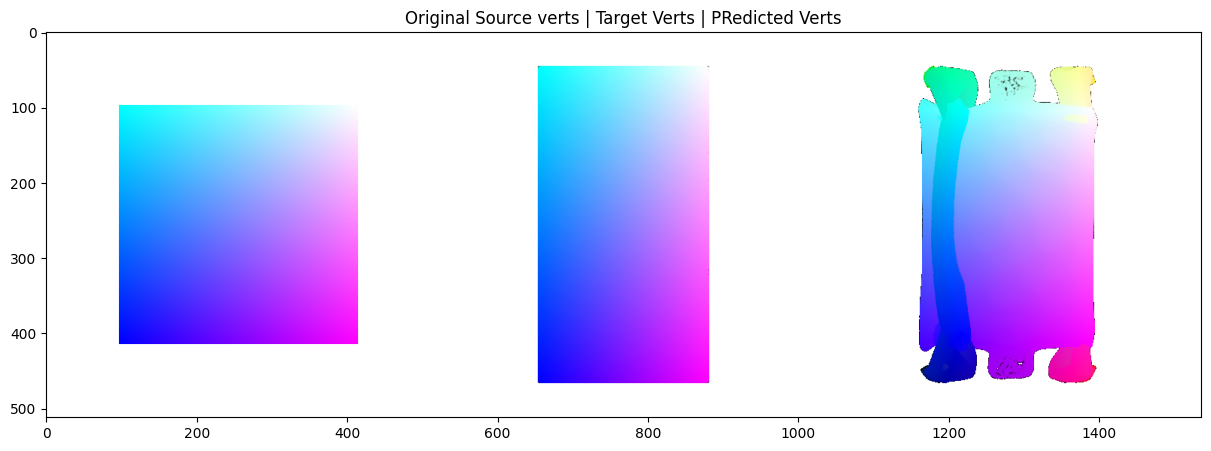

In [23]:
# visualise predicted mesh


#pcd_pred_rend = render_points_color(x=vpred[:, :3],c=vpred[:, 3:]).detach().cpu().numpy()
pcd_pred_rend = render_points_color(x=vpred,c=vsrc_col).detach().cpu().numpy()
y1 = np.hstack([yvsrc_print_1, yvtrg_print_1, pcd_pred_rend]).clip(0,1)

plt.figure(figsize=(20, 5))
plt.title("Original Source verts | Target Verts | PRedicted Verts")
plt.imshow(y1)

Chamfer distance Source to Target : 0.247506
Chamfer distance Predicted to Source : 0.286792
Chamfer distance Predicted to Target : 0.023773


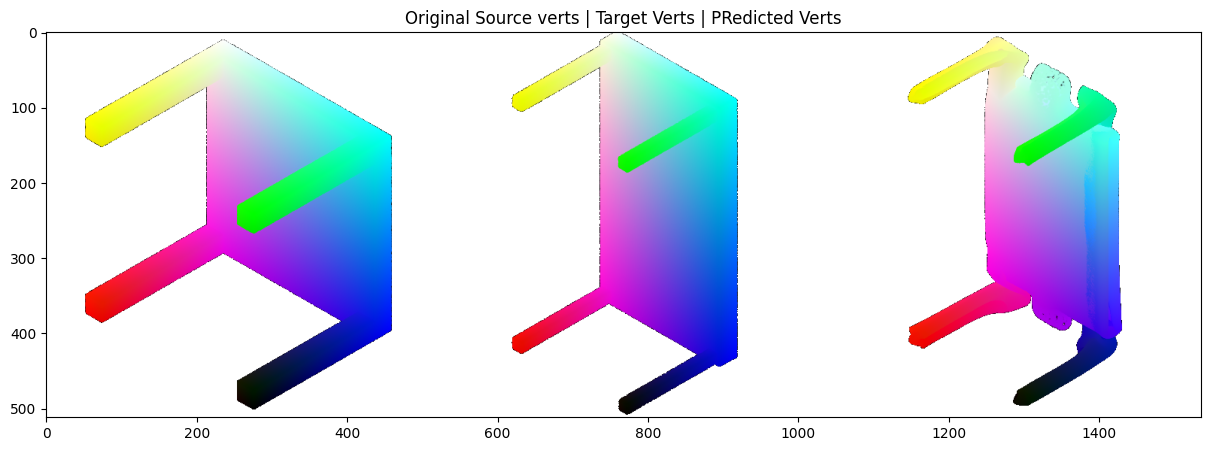

In [24]:
yvsrc= render_points_color(x = vsrc_pos,c=vsrc_col, elev=145, azim=45)

#yvtrg = render_points_color(vtrg.to(DEVICE)).detach().cpu().numpy()
yvtrg= render_points_color(x =vtrg_pos,c=vtrg_col, elev=145, azim=45)

yvsrc_print=yvsrc.cpu().detach().numpy()
yvtrg_print=yvtrg.cpu().detach().numpy()

pcd_pred_rend = render_points_color(x=vpred,c=vsrc_col, elev=145, azim=45).detach().cpu().numpy()

#yvsrc_print=yvsrc.cpu().detach().numpy()
#yvtrg_print=yvtrg.cpu().detach().numpy()

y2 = np.hstack([yvsrc_print, yvtrg_print, pcd_pred_rend]).clip(0,1)

plt.figure(figsize=(20, 5))
plt.title("Original Source verts | Target Verts | PRedicted Verts")
plt.imshow(y2)

l2_chamfer, _ = chamfer_distance(vsrc_pos.unsqueeze(0), vtrg_pos.unsqueeze(0),norm=1)
print("Chamfer distance Source to Target : %f" % (float(l2_chamfer)))
l2_chamfer, _ = chamfer_distance(vpred.unsqueeze(0), vsrc_pos.unsqueeze(0),norm=1)
print("Chamfer distance Predicted to Source : %f" % (float(l2_chamfer)))
l2_chamfer, _ = chamfer_distance(vpred.unsqueeze(0), vtrg_pos.unsqueeze(0),norm=1)
print("Chamfer distance Predicted to Target : %f" % (float(l2_chamfer)))

In [25]:
#### Other (prepared) Objects

In [26]:
#If other "Precorcessed" Object should be tested

test_file='pcd_table0025.ply'
#test_file='pcd_dino_3.ply'
#test_file='pcd_chair0003.ply'
#test_file='pcd_sofa0045.ply'
# here the test file will be the "new source" its distinct cause another pointcloud is used then the original source

mesh_gt_test = torch.Tensor(pcu.load_mesh_v(test_file))

vtest_norm_colors,_,_=normalize_verts_color(torch.tensor(mesh_gt_test).to(DEVICE))
vtest_norm_colors=vtest_norm_colors.detach().clone()
vtest_pos = vtest_norm_colors[:, :3]
vtest_col = vtest_norm_colors[:, 3:]

vtest_pos_tensor = torch.Tensor(vtest_pos).to(DEVICE)



# Pass vsrc to the model for prediction
model_output_vtest = model(vtest_pos_tensor)
tensor_from_model_output_vtest = model_output_vtest[0]

# Compute the predicted vertices
vpred_test = vtest_pos_tensor + tensor_from_model_output_vtest.detach().clone()

/tmp/ipykernel_32848/1265805226.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vtest_norm_colors,_,_=normalize_verts_color(torch.tensor(mesh_gt_test).to(DEVICE))


Chamfer distance Source to Target : 0.247506
Chamfer distance Predicted to Source : 0.286792
Chamfer distance Predicted to Target : 0.023773


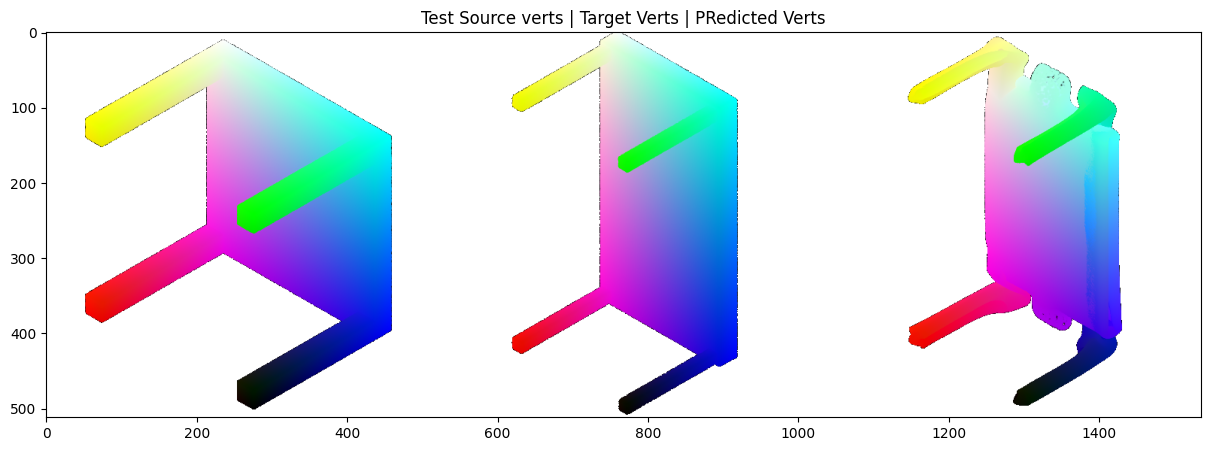

In [27]:
#rendering of the test object

yvtest= render_points_color(x = vtest_pos,c=vtest_col, elev=145, azim=45)


yvtrg= render_points_color(x =vtrg_pos,c=vtrg_col, elev=145, azim=45)

yvtest_print=yvtest.cpu().detach().numpy()
yvtrg_print=yvtrg.cpu().detach().numpy()

pcd_pred_test_rend = render_points_color(x=vpred_test,c=vtest_col, elev=145, azim=45).detach().cpu().numpy()

#yvsrc_print=yvsrc.cpu().detach().numpy()
#yvtrg_print=yvtrg.cpu().detach().numpy()

y2 = np.hstack([yvtest_print, yvtrg_print, pcd_pred_test_rend]).clip(0,1)

plt.figure(figsize=(20, 5))
plt.title("Test Source verts | Target Verts | PRedicted Verts")
plt.imshow(y2)

l2_chamfer, _ = chamfer_distance(vsrc_pos.unsqueeze(0), vtrg_pos.unsqueeze(0),norm=1)
print("Chamfer distance Source to Target : %f" % (float(l2_chamfer)))
l2_chamfer, _ = chamfer_distance(vpred_test.unsqueeze(0), vsrc_pos.unsqueeze(0),norm=1)
print("Chamfer distance Predicted to Source : %f" % (float(l2_chamfer)))
l2_chamfer, _ = chamfer_distance(vpred_test.unsqueeze(0), vtrg_pos.unsqueeze(0),norm=1)
print("Chamfer distance Predicted to Target : %f" % (float(l2_chamfer)))

In [28]:
# with keypoints

In [29]:

#keypoints_table_0020=[74,25,44,11,134,35,110,120,215,219,39,168,3,59,50,30,36,162,126,171,197,194]
keypoints_table_0020=[74,25,44,120,215,219,3,59,50,162,126,171]
#keypoints_table_0025=[10,15,13,2,14,3,16,6,9,21,18,7,11,5,17,8,19,20,12,22,17,0,1,18]
keypoints_table_0025=[15,13,3,10,13,2,18,7,11,5,8,20]
#key_table_0031=[434,282,353,614,479,412,485,71,96,63,414,22,107,554,441,559]
ksrc_id=keypoints_table_0025
ktrg_id=keypoints_table_0020


ksrc=vsrc_pos[ksrc_id].cpu().detach().numpy()
ktrg=vtrg_pos[ktrg_id].cpu().detach().numpy()
# Match the keypoints, by using the indices to get the matching kaypoints from the target
#matched_indices = match_keypoints(ksrc, ktrg)
#ktrg_matched = ktrg[matched_indices]

#ksrc_tensor = torch.Tensor(ksrc).to(DEVICE)
#ktrg_tensor = torch.Tensor(ktrg_matched).to(DEVICE)

ksrc_tensor = torch.Tensor(ksrc).to(DEVICE)
ktrg_tensor = torch.Tensor(ktrg).to(DEVICE)


In [30]:
# define our deformation function

model = Siren(in_features=3,
                hidden_features=128,
                hidden_layers=3,
                out_features=3, outermost_linear=True,
                first_omega_0=30, hidden_omega_0=30.).to(DEVICE).train()

# AIAP weight is an important hyperparameter which helps control
# the isometry of the deformation: the higher the AIAP_WEIGHT,
# the more isometric (constrained) is the predicted deformation

keypoints_source=ksrc_tensor
keypoints_target=ktrg_tensor

#AIAP_WEIGHT = 1.0e3
#CHAMFER_WEIGHT=1.0e3
GUIDED_WEIGHT=1.0e3

deform_cloud(model,
             xsrc=vsrc_pos, xtrg=vtrg_pos,vsrc=keypoints_source,vtrg=keypoints_target,
             init_lr=1.0e-4,
             n_steps=6000,                               
             use_chamfer=True,
             use_guidance=True,
             use_aiap=True,
             aiap_weight=AIAP_WEIGHT,
             guided_weight=GUIDED_WEIGHT,
             chamfer_weight=CHAMFER_WEIGHT,
             device=DEVICE)

# start training

00000 total loss: 457.442322, guidl: 417.904510, chaml. :36.879227, AIAP: 2.658598
00100 total loss: 129.052696, guidl: 115.186891, chaml. :5.194155, AIAP: 8.671650
00200 total loss: 28.989559, guidl: 19.612254, chaml. :1.396473, AIAP: 7.980832
00300 total loss: 20.801959, guidl: 12.764082, chaml. :1.323779, AIAP: 6.714097
00400 total loss: 19.288828, guidl: 12.153247, chaml. :1.253315, AIAP: 5.882266
00500 total loss: 18.116244, guidl: 11.519639, chaml. :1.226767, AIAP: 5.369838
00600 total loss: 17.621074, guidl: 11.394069, chaml. :1.213092, AIAP: 5.013912
00700 total loss: 17.891363, guidl: 11.837792, chaml. :1.206810, AIAP: 4.846761
00800 total loss: 17.244033, guidl: 11.440261, chaml. :1.192653, AIAP: 4.611120
00900 total loss: 16.836927, guidl: 11.250599, chaml. :1.185079, AIAP: 4.401248
01000 total loss: 16.378150, guidl: 11.052467, chaml. :1.171677, AIAP: 4.154005
01100 total loss: 16.738628, guidl: 11.462718, chaml. :1.168615, AIAP: 4.107295
01200 total loss: 16.581749, guidl:

In [31]:
model_output_vtest = model(vtest_pos_tensor)
tensor_from_model_output_vtest = model_output_vtest[0]

# Compute the predicted vertices
vpred_test = vtest_pos_tensor + tensor_from_model_output_vtest.detach().clone()

Chamfer distance Source to Target : 0.247506
Chamfer distance Predicted to Source : 0.294193
Chamfer distance Predicted to Target : 0.030550


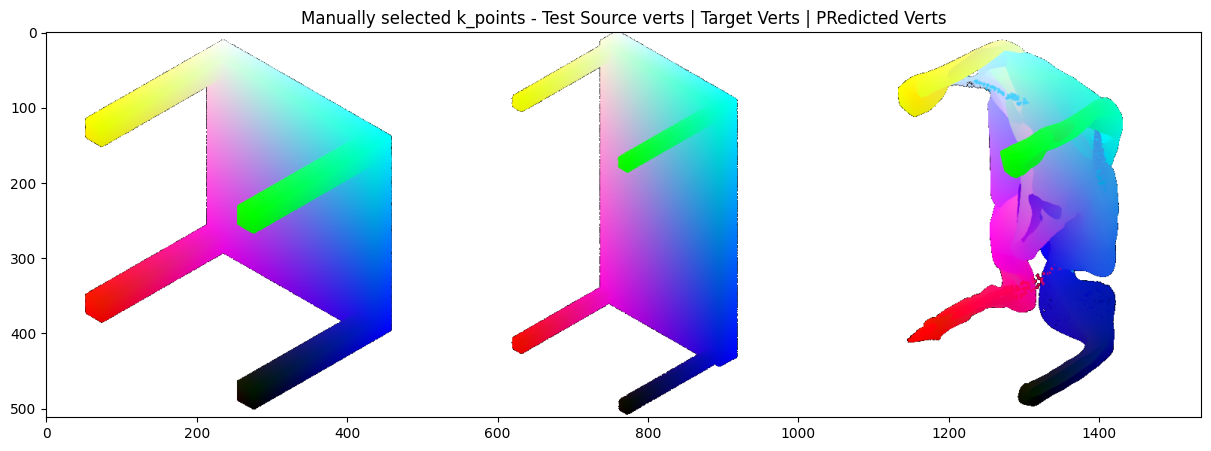

In [32]:
yvtest= render_points_color(x = vtest_pos,c=vtest_col, elev=145, azim=45)

yvtrg= render_points_color(x =vtrg_pos,c=vtrg_col, elev=145, azim=45)

yvtest_print=yvtest.cpu().detach().numpy()
yvtrg_print=yvtrg.cpu().detach().numpy()

pcd_pred_test_rend = render_points_color(x=vpred_test,c=vtest_col, elev=145, azim=45).detach().cpu().numpy()

#yvsrc_print=yvsrc.cpu().detach().numpy()
#yvtrg_print=yvtrg.cpu().detach().numpy()

y2 = np.hstack([yvtest_print, yvtrg_print, pcd_pred_test_rend]).clip(0,1)

plt.figure(figsize=(20, 5))
plt.title("Manually selected k_points - Test Source verts | Target Verts | PRedicted Verts")
plt.imshow(y2)

l2_chamfer, _ = chamfer_distance(vsrc_pos.unsqueeze(0), vtrg_pos.unsqueeze(0),norm=1)
print("Chamfer distance Source to Target : %f" % (float(l2_chamfer)))
l2_chamfer, _ = chamfer_distance(vpred_test.unsqueeze(0), vsrc_pos.unsqueeze(0),norm=1)
print("Chamfer distance Predicted to Source : %f" % (float(l2_chamfer)))
l2_chamfer, _ = chamfer_distance(vpred_test.unsqueeze(0), vtrg_pos.unsqueeze(0),norm=1)
print("Chamfer distance Predicted to Target : %f" % (float(l2_chamfer)))

00000 total loss: 154.587234, guidl: 113.490273, chaml. :38.275818, AIAP: 2.821143
00100 total loss: 25.613400, guidl: 16.139200, chaml. :4.758235, AIAP: 4.715966
00200 total loss: 9.465796, guidl: 4.247561, chaml. :1.423424, AIAP: 3.794811
00300 total loss: 7.232610, guidl: 2.662762, chaml. :1.278449, AIAP: 3.291399
00400 total loss: 6.352548, guidl: 2.125857, chaml. :1.219080, AIAP: 3.007611
00500 total loss: 5.692615, guidl: 1.678121, chaml. :1.185665, AIAP: 2.828829
00600 total loss: 5.374834, guidl: 1.511057, chaml. :1.156579, AIAP: 2.707198
00700 total loss: 5.076312, guidl: 1.321073, chaml. :1.137154, AIAP: 2.618085
00800 total loss: 4.798225, guidl: 1.128509, chaml. :1.122080, AIAP: 2.547635
00900 total loss: 4.603922, guidl: 1.036506, chaml. :1.106097, AIAP: 2.461319
01000 total loss: 4.445758, guidl: 0.985366, chaml. :1.078722, AIAP: 2.381670
01100 total loss: 4.320783, guidl: 0.957458, chaml. :1.053785, AIAP: 2.309540
01200 total loss: 4.264238, guidl: 0.945228, chaml. :1.04

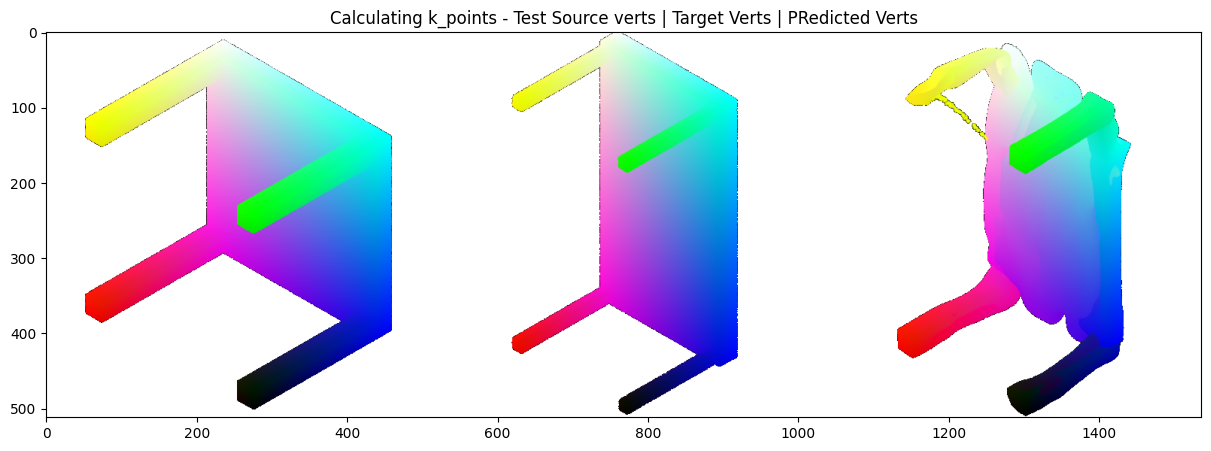

In [33]:


vsrc_np=vsrc_norm_colors[:, :3].cpu().numpy()
vtrg_np=vtrg_norm_colors[:, :3].cpu().numpy()

ksrc_id = find_ground_points(vsrc_np)
ktrg_id = find_ground_points(vtrg_np)

ksrc=vsrc_pos[ksrc_id].cpu().detach().numpy()
ktrg=vtrg_pos[ktrg_id].cpu().detach().numpy()
# Match the keypoints, by using the indices to get the matching kaypoints from the target
matched_indices = match_keypoints(ksrc, ktrg)
ktrg_matched = ktrg[matched_indices]

ksrc_tensor = torch.Tensor(ksrc).to(DEVICE)
ktrg_tensor = torch.Tensor(ktrg_matched).to(DEVICE)


# define our deformation function

model = Siren(in_features=3,
                hidden_features=128,
                hidden_layers=3,
                out_features=3, outermost_linear=True,
                first_omega_0=30, hidden_omega_0=30.).to(DEVICE).train()

# AIAP weight is an important hyperparameter which helps control
# the isometry of the deformation: the higher the AIAP_WEIGHT,
# the more isometric (constrained) is the predicted deformation

keypoints_source=ksrc_tensor
keypoints_target=ktrg_tensor

AIAP_WEIGHT = 1.0e3
CHAMFER_WEIGHT=1e3
GUIDED_WEIGHT=1e3

deform_cloud(model,
             xsrc=vsrc_pos, xtrg=vtrg_pos,vsrc=keypoints_source,vtrg=keypoints_target,
             init_lr=1.0e-4,
             n_steps=6000,                               
             use_chamfer=True,
             use_guidance=True,
             use_aiap=True,
             aiap_weight=AIAP_WEIGHT,
             guided_weight=GUIDED_WEIGHT,
             chamfer_weight=CHAMFER_WEIGHT,
             device=DEVICE)

# start training





model_output_vtest = model(vtest_pos_tensor)
tensor_from_model_output_vtest = model_output_vtest[0]

# Compute the predicted vertices
vpred_test = vtest_pos_tensor + tensor_from_model_output_vtest.detach().clone()




yvtest= render_points_color(x = vtest_pos,c=vtest_col, elev=145, azim=45)

yvtrg= render_points_color(x =vtrg_pos,c=vtrg_col, elev=145, azim=45)

yvtest_print=yvtest.cpu().detach().numpy()
yvtrg_print=yvtrg.cpu().detach().numpy()

pcd_pred_test_rend = render_points_color(x=vpred_test,c=vtest_col, elev=145, azim=45).detach().cpu().numpy()

#yvsrc_print=yvsrc.cpu().detach().numpy()
#yvtrg_print=yvtrg.cpu().detach().numpy()

y2 = np.hstack([yvtest_print, yvtrg_print, pcd_pred_test_rend]).clip(0,1)

plt.figure(figsize=(20, 5))
plt.title("Calculating k_points - Test Source verts | Target Verts | PRedicted Verts")
plt.imshow(y2)

l2_chamfer, _ = chamfer_distance(vsrc_pos.unsqueeze(0), vtrg_pos.unsqueeze(0),norm=1)
print("Chamfer distance Source to Target : %f" % (float(l2_chamfer)))
l2_chamfer, _ = chamfer_distance(vpred_test.unsqueeze(0), vsrc_pos.unsqueeze(0),norm=1)
print("Chamfer distance Predicted to Source : %f" % (float(l2_chamfer)))
l2_chamfer, _ = chamfer_distance(vpred_test.unsqueeze(0), vtrg_pos.unsqueeze(0),norm=1)
print("Chamfer distance Predicted to Target : %f" % (float(l2_chamfer)))